<a href="https://colab.research.google.com/github/moo0la/final_peoject/blob/main/ML_Bitcoin_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
import arch


In [3]:
url = 'https://api.binance.com/api/v3/klines'



r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1d','limit':2000})
r


<Response [200]>

In [4]:
collumns = """

1499040000000,      // Open time
    "0.01634790",       // Open
    "0.80000000",       // High
    "0.01575800",       // Low
    "0.01577100",       // Close
    "148976.11427815",  // Volume
    1499644799999,      // Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "17928899.62484339" // Ignore.

""".split("//")[1:-1]


my_col_names = [sub_str.split('\n')[0].lower().strip().replace(' ','_') for sub_str in collumns]
# my_col_names.insert(0, 'timestamp')
my_col_names.append('ignore')
my_col_names

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_asset_volume',
 'taker_buy_quote_asset_volume',
 'ignore']

In [5]:
df = pd.DataFrame(r.json(),columns = my_col_names)
df.index = pd.to_datetime(df.open_time*1000000)
#df.index = pd.DatetimeIndex(df.open_time*1000000)
df.index.name = 'Date'
df = df.drop(columns=['open_time','close_time','ignore'])
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
Date,,,,,,,,,
2019-04-17,5173.72000000,5230.40000000,5146.80000000,5202.82000000,23307.53613400,120972345.51821637,179490,12172.53172400,63190167.89632924
2019-04-18,5202.41000000,5287.00000000,5198.80000000,5258.44000000,22619.23900100,118573129.86520114,167110,12104.85293200,63464128.54331125
2019-04-19,5258.44000000,5320.00000000,5175.00000000,5258.68000000,24611.23632300,128937309.63806376,178148,12889.68334400,67549701.12506344
2019-04-20,5258.68000000,5333.42000000,5230.10000000,5291.73000000,19168.90827400,101343660.15324434,157080,10029.27226200,53029542.91017945
2019-04-21,5292.91000000,5314.35000000,5165.00000000,5256.14000000,25549.57093900,133929931.15068736,210494,13147.77101600,68909870.81367928
...,...,...,...,...,...,...,...,...,...
2022-01-06,43451.14000000,43816.00000000,42430.58000000,43082.31000000,38880.37305000,1674466154.43833260,1150707,19268.82662000,829886561.82614530
2022-01-07,43082.30000000,43145.83000000,40610.00000000,41566.48000000,54836.50818000,2293851015.46523690,1406635,26519.39261000,1109740200.23872120
2022-01-08,41566.48000000,42300.00000000,40501.00000000,41679.74000000,32952.73111000,1367233494.82776660,1021908,16462.53747000,683155535.42153480


In [6]:
r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1d','limit':2000,'endTime':(1641348720-1)*2000})
pd.DatetimeIndex(pd.DataFrame(r.json(),columns = my_col_names).open_time*1000000)

DatetimeIndex(['2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20',
               '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24',
               '2019-04-25', '2019-04-26',
               ...
               '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10'],
              dtype='datetime64[ns]', name='open_time', length=1000, freq=None)

In [7]:
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [8]:
df['taker_sell_base_asset_volume'] = df.volume - df.taker_buy_base_asset_volume
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume
Date,,,,,,,,,,
2019-04-17,5173.72,5230.40,5146.80,5202.82,23307.536134,1.209723e+08,179490,12172.531724,6.319017e+07,11135.004410
2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.239001,1.185731e+08,167110,12104.852932,6.346413e+07,10514.386069
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923
...,...,...,...,...,...,...,...,...,...,...
2022-01-06,43451.14,43816.00,42430.58,43082.31,38880.373050,1.674466e+09,1150707,19268.826620,8.298866e+08,19611.546430
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640


In [9]:
df['order_flow_imbalance'] = 1-(df.taker_sell_base_asset_volume/df.taker_buy_base_asset_volume)
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance
Date,,,,,,,,,,,
2019-04-17,5173.72,5230.40,5146.80,5202.82,23307.536134,1.209723e+08,179490,12172.531724,6.319017e+07,11135.004410,0.085235
2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.239001,1.185731e+08,167110,12104.852932,6.346413e+07,10514.386069,0.131391
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979,0.090625
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,43451.14,43816.00,42430.58,43082.31,38880.373050,1.674466e+09,1150707,19268.826620,8.298866e+08,19611.546430,-0.017786
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680


In [10]:
df['price_change'] = df.close.pct_change()
df = df.dropna()
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance,price_change
Date,,,,,,,,,,,,
2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.239001,1.185731e+08,167110,12104.852932,6.346413e+07,10514.386069,0.131391,0.010690
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979,0.090625,0.000046
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704,0.006285
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737,-0.006726
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458,0.132181,0.019216
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,43451.14,43816.00,42430.58,43082.31,38880.373050,1.674466e+09,1150707,19268.826620,8.298866e+08,19611.546430,-0.017786,-0.008488
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789,-0.035185
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680,0.002725


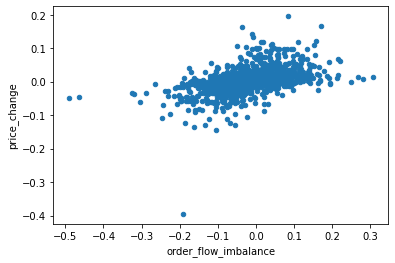

In [11]:
df.plot.scatter(x='order_flow_imbalance',y='price_change')

In [12]:
df["low"] = pd.to_numeric(df["low"])
df["high"] = pd.to_numeric(df["high"])
df['Mean'] = (df['low'] + df['high'])/2
df=df.dropna()
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance,price_change,Mean
Date,,,,,,,,,,,,,
2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.239001,1.185731e+08,167110,12104.852932,6.346413e+07,10514.386069,0.131391,0.010690,5242.900
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979,0.090625,0.000046,5247.500
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704,0.006285,5281.760
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737,-0.006726,5239.675
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458,0.132181,0.019216,5304.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,43451.14,43816.00,42430.58,43082.31,38880.373050,1.674466e+09,1150707,19268.826620,8.298866e+08,19611.546430,-0.017786,-0.008488,43123.290
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789,-0.035185,41877.915
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680,0.002725,41400.500


In [13]:
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['price_change'].shift()
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance,price_change,Mean,Actual
Date,,,,,,,,,,,,,,
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979,0.090625,0.000046,5247.500,0.010690
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704,0.006285,5281.760,0.000046
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737,-0.006726,5239.675,0.006285
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458,0.132181,0.019216,5304.175,-0.006726
2019-04-23,5357.14,5600.00,5332.41,5493.31,41262.103917,2.271541e+08,282563,21260.014469,1.170548e+08,20002.089448,0.059169,0.025418,5466.205,0.019216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,43451.14,43816.00,42430.58,43082.31,38880.373050,1.674466e+09,1150707,19268.826620,8.298866e+08,19611.546430,-0.017786,-0.008488,43123.290,-0.051948
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789,-0.035185,41877.915,-0.008488
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680,0.002725,41400.500,-0.035185


In [14]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
N=2411

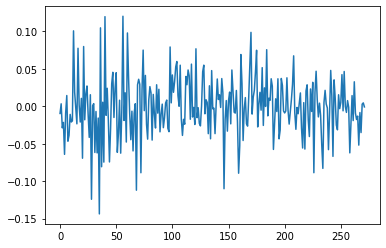

In [15]:
X=[]
for i in range(2411):
    X.append([i])
X=np.array(X)
Xtrain=X[:N]
Xtest=X[-272:]
Y=df["price_change"]
Y=np.array(Y,dtype='float32')
ytrain=Y[:N]
ytest=Y[-272:]
arr=ytest
plt.plot(arr,label='actual')

In [16]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'price_change']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X= scaled_input
X.rename(columns={0:'low', 1:'high', 2:'open', 3:'close', 4:'volume', 5:'price_change'}, inplace=True)
print(X.head())

                 low      high      open     close    volume  price_change
Date                                                                      
2019-04-19  0.022307  0.000089  0.007308  0.007312  0.043162      0.669186
2019-04-20  0.023190  0.000299  0.007312  0.007839  0.029371      0.679754
2019-04-21  0.022147  0.000000  0.007858  0.007272  0.045540      0.657717
2019-04-22  0.022841  0.001345  0.007292  0.008882  0.055713      0.701655
2019-04-23  0.024828  0.004485  0.008882  0.011053  0.085357      0.712161


In [17]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
print(y.head())

            BTC Price next day
Date                          
2019-04-19            0.687216
2019-04-20            0.669186
2019-04-21            0.679754
2019-04-22            0.657717
2019-04-23            0.701655


In [18]:
train_size=int(len(df) *0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [20]:
predic_garch =[]
for i in range(test_size):
  model= SARIMAX(pd.concat([train_y,test_y.iloc[:i+1]]),
  exog=pd.concat([train_X,test_X.iloc[:i+1]]),
  order=(0,1,1),
  seasonal_order =(0, 0, 1, 12),
  enforce_invertibility=False, enforce_stationarity=False)
  results= model.fit()
  garch = arch.arch_model(results.resid, p=1, q=1,vol='GARCH')
  garch_model = garch.fit(update_freq=1)
  garch_forecast = garch_model.forecast(start = train_size-1,horizon=1,method='simulation')
  predicted_et = garch_forecast.mean['h.1'].iloc[-1]
  predic_garch.append(predicted_et)
  print(predicted_et)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1152.2123955881725
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1152.5524394852218
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1152.74863228224
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1152.9527553293403
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1153.173079250942
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1153.22285212164
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1153.2816175657354
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1153.3899800790869
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1153.3912731158687
Iteration:     10,   Func. Count:     74,   Neg. LLF: -1153.3912751509224
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1153.3912751510043
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10
4.218697223507e-06


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1153.0777204923345
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1153.4377766553312
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1153.6431688758369
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1153.91860539883
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1154.085775274382
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1154.181918932893
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1154.2029854813686
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1154.2110370080554
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1154.2118803885248
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1154.2118833643665
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1154.2118833643735
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
-4.770451349214973e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1155.0587374803156
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1155.2734473047944
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1155.4442144992909
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1155.6327619131018
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1155.9066443713043
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1155.944708617783
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1155.9684227618993
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1155.9688285720215
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1155.968829295446
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
0.00030288971440555303


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1155.421475712306
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1155.7815134324583
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1156.021013253334
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1156.3089278482194
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1156.4619941575215
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1156.5445475760523
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1156.5616659168527
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1156.567678751077
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1156.567886408219
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1156.567886868599
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
0.000183858829166926


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1155.9709535418367
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1156.3208567402694
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1156.557382967435
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1156.815530846859
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1156.9891674575392
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1157.0665564724115
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1157.083311613996
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1157.1022563998413
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1157.1026834948598
Iteration:     10,   Func. Count:     77,   Neg. LLF: -1157.1026845614886
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1157.1026845614392
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
8.623924291828154e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1154.7883317684973
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1155.36606167921
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1156.0473708259478
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1156.068263713738
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1156.0815042291192
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1156.0820373916504
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1156.0828102358496
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1156.0828353017696
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1156.0828353012228
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
0.00013634734758574034


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1159.3662771065997
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1159.678913260269
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1159.87509753861
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1160.1194093676625
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1160.423264853487
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1160.4388240076626
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1160.4963504567074
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1160.507844834703
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1160.5078856619102
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1160.5078856619657
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
4.571737742555204e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1161.1988596399128
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1161.522799960333
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1161.7594770776534
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1162.031002177755
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1162.3077414399554
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1162.3254512323551
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1162.3461304984332
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1162.3636976022551
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1162.3638308428522
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1162.3638313112901
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
0.00011698344938021285


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1162.8642463582812
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1163.2297214977787
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1163.420794487054
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1163.6145629527591
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1163.768627866892
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1163.8285821889174
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1164.0255378681998
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1164.0531490825272
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1164.055439387549
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1164.055478750668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1164.0554797452048
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
0.00022646421286275225


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1164.0570242960898
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1164.3393897292713
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1164.5912029878696
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1164.7449636674282
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1165.0461002114944
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1165.0498645799673
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1165.2306154026055
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1165.2729705793595
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1165.2759840021868
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1165.2760303550858
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1165.2760309310806
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
0.00016084307957328246


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1161.7547287610512
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1161.8381084230878
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1162.3347901416416
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1162.7062492776847
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1162.7168876040205
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1162.7212037761628
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1162.727358239964
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1162.7274384013458
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1162.7274426042666
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1162.7274426042313
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
-0.0009849238951681611


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1163.653349596003
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1164.1863590170683
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1164.945382894049
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1164.9861558049606
Iteration:      5,   Func. Count:     46,   Neg. LLF: -1164.988622778102
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1164.9903276602922
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1164.9905490846388
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1164.9905490839938
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
1.7337639859018946e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1167.888818378377
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1168.1370407321065
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1168.344450853528
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1168.4943329980788
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1169.0368836414384
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1169.0568274931952
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1169.130726393661
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1169.1520103925636
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1169.1528202034401
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1169.152836981048
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1169.1528369810076
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
0.0003249293049527698


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1171.4987679168532
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1171.692908755601
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1171.8899366976912
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1172.1828340129384
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1172.5032034364024
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1172.527639336054
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1172.7959850179927
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1172.8562290684617
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1172.8615525540863
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1172.8616767100045
Iteration:     11,   Func. Count:     81,   Neg. LLF: -1172.8616836360804
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1172.8616836366841
            Iterations: 11
            Function evaluations: 81
            G

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1171.1042982183726
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1171.3723677455182
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1171.8695596251612
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1172.094021456352
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1172.2927145767417
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1172.2933657397723
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1172.3048921974867
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1172.3055549835121
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1172.3055834185323
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1172.3055834182433
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
0.00020994978251111723


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1172.997227992188
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1173.2395172968158
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1173.4592825065165
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1173.5936646611403
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1174.0886109223843
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1174.0980933016215
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1174.177642358734
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1174.19945014072
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1174.2001807240924
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1174.2001914894813
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1174.2001914896246
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
0.00025741407002639476


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1172.3963560795805
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1173.0024359980478
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1173.6793438063623
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1173.7135447918888
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1173.7339862783479
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1173.7359768018582
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1173.7363415494506
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1173.7363482202427
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1173.7363482199266
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
0.00025515294533908433


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1176.919312462016
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1177.5860675699075
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1178.2889816544211
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1178.4020587509917
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1178.4164083302016
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1178.4202758621623
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1178.4208271521657
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1178.4208472691937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1178.4208472689247
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
0.0003898706144394528


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1176.3331616969585
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1176.6690404328501
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1177.2142026523875
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1177.2988332360965
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1177.5163678163644
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1177.5462622549144
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1177.5521342864004
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1177.5557702755316
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1177.5558097580981
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1177.5558097578987
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
0.00010414214560654301


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1176.7255501455643
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1177.3544826364027
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1178.0481622947434
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1178.121153362357
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1178.1669370393174
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1178.1846223681114
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1178.1856700567696
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1178.1873413969074
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1178.1874068716857
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1178.1874073416852
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 9
3.977803678991909e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1179.1733323305257
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1179.4415292923068
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1179.9842782245905
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1180.2156688925056
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1180.3674120194505
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1180.3675685971753
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1180.376969610716
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1180.3773710827286
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1180.3773876122973
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1180.3773876120358
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
6.075977597026605e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1181.121858370775
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1181.4094368337296
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1181.6587363496042
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1181.7694639571787
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1182.2157922043566
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1182.222227950353
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1182.287240446673
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1182.3050796709588
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1182.3052848495552
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1182.3052894265963
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1182.3052894266466
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
6.298451690045746e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1182.4029870989348
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1182.9623566270825
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1183.2089169561011
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1183.3130208479934
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1183.542795801483
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1183.6850774987738
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1183.6918899914428
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1183.6929719562127
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1183.692980485925
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1183.6929804865035
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
1.1502004117963323e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1182.3777682946786
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1182.7375972268533
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1183.3371799233914
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1183.3890717004247
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1183.475340416649
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1183.534698023132
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1183.539261487344
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1183.5396130532513
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1183.5396176207807
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1183.5396176207496
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-7.305735019216174e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1184.094094344773
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1184.3997196092164
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1185.003097374246
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1185.0685764155255
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1185.2475521435294
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1185.2982712213689
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1185.3007927741096
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1185.3027838455023
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1185.3050248937616
Iteration:     10,   Func. Count:     77,   Neg. LLF: -1185.3050265894194
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1185.3050265893644
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
-0.0001386468240972085


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1186.1382305179175
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1186.472847817937
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1187.020808924833
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1187.0713715944803
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1187.2131049344118
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1187.284956998309
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1187.2905598405316
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1187.290824353259
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1187.2911648495642
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1187.2911661496116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1187.29116614946
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
-0.00010753414635636143


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1187.6465251507368
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1187.9777979688506
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1188.5482004814667
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1188.6046953403716
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1188.7222893061016
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1188.7964629705643
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1188.800868408723
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1188.8012559125048
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1188.80183509823
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1188.8018354378203
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-0.00014653901226585142


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1186.0708589336093
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1186.6080060873303
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1187.733103693763
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1187.8526603792498
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1187.876755490515
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1187.9783711506452
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1187.9848266634328
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1187.988726032758
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1187.988755652576
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1187.9887556528693
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-9.726748298373892e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1192.5040416584839
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1192.8459498833254
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1193.0735087021508
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1193.3333015082712
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1193.4873588880628
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1193.512043383816
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1193.5639776227288
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1193.5653043043044
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1193.565324955544
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1193.565324955026
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
-0.00019313184699402635


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1193.3874631168387
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1193.7459062662629
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1193.9867403165927
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1194.082094187324
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1194.3098994447362
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1194.4290310739018
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1194.4513360818337
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1194.4778998631753
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1194.4829640946855
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1194.4832658679443
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1194.4832658680411
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
-0.0002085606287300146


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1189.3363539106667
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1189.5203745580693
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1190.246815301653
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1190.3958076899494
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1190.3992827102106
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1190.4035633136905
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1190.4052605098664
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1190.4052775153486
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1190.4052788128345
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1190.40527881283
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
-0.0013534130885573432


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1196.5777356248575
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1196.9387011357103
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1197.1575041782762
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1197.2443192605338
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1197.4570675865598
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1197.6173783512181
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1197.6416941567795
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1197.653038395435
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1197.6530643398871
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1197.6530643393787
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.0002136520777181671


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1193.4846669483345
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1193.840657117776
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1194.7246022190022
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1194.7561165937254
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1194.7696115872868
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1194.7731824649552
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1194.7736039304289
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1194.7736082832657
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1194.773608283263
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
-0.0005238004729232091


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1187.446409036228
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1187.557113990842
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1188.7368232045878
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1189.1858066956438
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1189.4387364958266
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1189.4576749745106
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1189.4904416924578
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1189.5297289433347
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1189.5304042523424
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1189.5304105820185
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1189.5304105822647
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
-0.00133347317651377


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1201.9831935714133
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1202.3360819885534
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1202.5841113743927
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1202.6981773673965
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1202.914307837407
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1203.0152464010312
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1203.048347770547
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1203.0756145330306
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1203.0808200780577
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1203.0810583174875
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1203.081058317542
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
-3.597960753205382e-05


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1208.7667739277388
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1209.0918432612075
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1209.2485653361239
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1209.4577968243484
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1209.749259033149
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1209.9305483206062
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1210.1748431744431
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1210.177014142705
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1210.177437741751
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1210.1774445860751
Iteration:     11,   Func. Count:     81,   Neg. LLF: -1210.1774458269215
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1210.1774458269147
            Iterations: 11
            Function evaluations: 81
            Gr

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1204.2646828683914
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1204.622313357675
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1205.1457128473003
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1205.2052382650122
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1205.301143542695
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1205.3512157492764
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1205.3569835595185
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1205.3573706729262
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1205.3573797388744
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1205.3573797388526
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.0002495526436401826


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1205.505088293281
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1205.8696357466952
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1206.0859994259479
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1206.1774863402825
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1206.357780079044
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1206.5410351608102
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1206.5469681712298
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1206.5474046498343
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1206.547628497031
Iteration:     10,   Func. Count:     74,   Neg. LLF: -1206.5476356616214
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1206.547635661011
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10
-0.00027999101244386023


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1206.614416567024
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1206.9673923139194
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1207.522143821504
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1207.567945462318
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1207.6587748152924
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1207.7128471455194
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1207.7175093465949
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1207.7178208133762
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1207.7178256953366
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1207.7178256953189
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.00032609175962041223


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1207.4031767518477
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1207.7685288428975
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1208.377117686479
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1208.4139120474476
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1208.4474787054987
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1208.4701004893336
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1208.4730220728445
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1208.4731074799397
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1208.4731102189783
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1208.4731102189771
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0004220043981099326


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1203.3827172473825
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1203.7093671755497
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1205.1166650358953
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1205.1692903468906
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1205.5826671453106
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1205.66589793797
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1205.6729446974473
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1205.6957246595373
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1205.6957530392951
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1205.6957530398506
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.00032895634068447487


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1211.2711007074709
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1211.6332405511557
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1211.8767869155527
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1211.9636438128566
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1212.0862812657724
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1212.3003887230782
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1212.3069716306195
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1212.308347918317
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1212.3085920368787
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1212.3086240268808
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1212.3086240268422
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
-0.00042925120272761417


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1213.473979192723
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1213.8234249797629
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1214.3421759222535
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1214.365062438646
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1214.4133660625125
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1214.4174618767913
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1214.4190739752405
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1214.4192134455268
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1214.4192150166218
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1214.419215016445
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.00015981960065168603


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1214.9388389080682
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1215.292306155039
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1215.8243048547743
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1215.8630817067497
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1215.9164511001504
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1215.9211093770564
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1215.9233900150346
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1215.9235245512427
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1215.9235270603854
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1215.9235270602458
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0004798532098911792


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1215.1472850948785
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1215.5091329060224
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1216.0909843830493
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1216.1355763273132
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1216.1965748943196
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1216.2084335394616
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1216.213396217522
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1216.2136499440687
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1216.2136582915323
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1216.2136582914209
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0005365317256046574


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1216.5027515568477
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1216.850029728358
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1217.198168473095
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1217.2985231035311
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1217.384397838869
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1217.5410751365462
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1217.582351602992
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1217.605401043295
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1217.6328727271357
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1217.63289435462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1217.6328943545118
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
-0.000473132062951308


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1217.095181397706
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1217.4570700857548
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1218.1019155987794
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1218.1557106438368
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1218.1948830682697
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1218.222449634166
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1218.2265180188656
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1218.226647019218
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1218.2266516935815
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1218.226651693559
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0005369725183443076


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1218.8873926830515
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1219.2540199104253
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1219.8804439083317
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1219.9378824557598
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1219.9732386889546
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1219.9860155781494
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1219.9890420973088
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1219.9891501100296
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1219.989154076446
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1219.9891540764434
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0005725161597114875


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1217.2311303775055
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1217.564870352701
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1218.7946444133618
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1218.903437198735
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1219.2091705365547
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1219.21772180883
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1219.2478322589045
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1219.2508648174478
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1219.2509552257618
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1219.2509552249553
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.000454398285962037


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1223.9012338596017
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1224.4219660854142
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1224.972459494256
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1225.031629939984
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1225.0944966486522
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1225.0976344947612
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1225.1000307724084
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1225.1001077641517
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1225.1001092411168
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1225.1001092410495
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.00029976887162559603


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1223.362979421191
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1223.722673171339
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1224.3496160463094
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1224.4136050263614
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1224.447961405404
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1224.4588301966728
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1224.4617117245377
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1224.4618185321742
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1224.4618223584362
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1224.4618223584362
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0006382663269907298


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1225.0116897251903
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1225.3539375462722
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1225.9684584257798
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1226.0338670459078
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1226.0622930390603
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1226.069184691682
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1226.072253837672
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1226.0723831464727
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1226.0723880852215
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1226.0723880852374
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-0.0006743613225015001


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1225.1562690353694
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1225.2940012066251
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1225.93500865367
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1226.1416654830625
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1226.1618829072895
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1226.1678314449682
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1226.1695841799597
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1226.1696505440332
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1226.1696505437383
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
-0.0009728868070605868


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1228.8000549908352
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1229.1568419131172
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1229.715945370564
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1229.752633014928
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1229.8076272908118
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1229.8171516474708
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1229.8203438818578
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1229.8205189669452
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1229.8205220989337
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1229.82052209897
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-0.0005666857240468449


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1226.5906958164228
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1226.920007287737
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1227.6396085582091
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1227.7273751876737
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1227.797227398364
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1227.800389399593
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1227.8028573461743
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1227.802944879667
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1227.802947513445
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1227.8029475133922
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0007464096254612538


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1223.666921829361
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1223.748447643826
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1223.748450025588
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.0015960362855632427


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1219.0785321978055
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1219.0967753323534
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1219.09677758156
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.001847771650957528


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1230.993133887363
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1231.3440827242916
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1232.040599443184
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1232.1257021590234
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1232.1693235660837
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1232.174639855733
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1232.1769495657245
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1232.1770408095797
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1232.1770442890843
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1232.1770442890636
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0006461654388796134


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1229.750966832664
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1230.281491331787
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1231.6398239260252
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1231.7952269209122
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1231.9665205383671
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1231.9760088018602
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1231.9927976121714
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1231.9941328034884
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1231.9941392646015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1231.9941392649555
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.00047698940402179116


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1233.2317423670474
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1233.5988546314918
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1234.390066777978
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1234.4871878101426
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1234.494957992197
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1234.507545676602
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1234.5093324185918
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1234.5093608295965
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1234.5093629595353
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1234.5093629595533
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.0006846138783427675


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1235.5774078954428
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1235.8650683513542
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1236.5420153728473
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1236.6403560337951
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1236.6783084542997
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1236.6821492581669
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1236.6842329480155
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1236.6842748597917
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1236.6842759874175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1236.6842759874173
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0007907157980273988


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1237.7595298891401
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1238.046548707242
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1238.6689746052823
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1238.7841033273608
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1238.8477025551838
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1238.8679604276945
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1238.874017602137
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1238.8748479513772
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1238.8748479509754
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
-0.0009012651617183796


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1230.093122030224
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1230.153169863056
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1230.9503963349769
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1231.8439338774704
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1231.908318809
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1231.9235716028152
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1231.932753161868
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1231.9358193359276
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1231.9361413350039
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1231.936141335344
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-0.0011409597939039029


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1237.799383325827
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1238.0518196133985
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1238.867736061913
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1239.0130900283195
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1239.0182532274796
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1239.024910478755
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1239.0325989619687
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1239.032983963893
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1239.033003380588
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1239.0330033799914
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-0.0009630068125950608


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1236.0647348018538
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1236.1394397000972
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1236.953867115542
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1237.7134778896998
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1237.8111627988048
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1237.8178596237217
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1237.8247259191514
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1237.830708544384
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1237.830839581665
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1237.8308610350794
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1237.830861035028
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
-0.000981987269790683


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1238.441272892081
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1238.52502158164
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1238.6584529065426
Iteration:      4,   Func. Count:     38,   Neg. LLF: -1239.088993363934
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1239.0901253031584
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1239.091139275526
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1239.393069576564
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1240.4483295228272
Iteration:      9,   Func. Count:     85,   Neg. LLF: -1240.5400244344887
Iteration:     10,   Func. Count:     93,   Neg. LLF: -1240.5813787452857
Iteration:     11,   Func. Count:    101,   Neg. LLF: -1240.5826340752828
Iteration:     12,   Func. Count:    107,   Neg. LLF: -1240.6088139930707
Iteration:     13,   Func. Count:    113,   Neg. LLF: -1240.614090420594
Iteration:     14,   Func. Count:    119,   N

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1240.2313356915265
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1240.3073636115123
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1240.509778821288
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1241.1897329796743
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1241.9170205032747
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1242.3155276070231
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1242.4000076499344
Iteration:      8,   Func. Count:     67,   Neg. LLF: -1242.4066633704697
Iteration:      9,   Func. Count:     75,   Neg. LLF: -1242.4096652029502
Iteration:     10,   Func. Count:     81,   Neg. LLF: -1242.4271366391206
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1242.427257442474
Iteration:     12,   Func. Count:     93,   Neg. LLF: -1242.4272624701082
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1242.4272624700843
   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1240.6374300165796
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1240.7106557367204
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1240.7106580370128
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.0014850853160897285


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1241.9789903960936
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1242.0438602764668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1242.0438625298634
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.0015196749592051792


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1245.8433061616588
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1246.0001948867384
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1246.6129863101219
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1247.0540711909634
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1247.0613909184126
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1247.2259203421997
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1247.227834424782
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1247.2278937618426
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1247.2278945530134
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
-0.0011954011800787343


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1248.8404137778075
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1249.084093518669
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1250.1959086959691
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1250.4617897711737
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1250.5803308568743
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1250.6065050670154
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1250.6440174692339
Iteration:      8,   Func. Count:     66,   Neg. LLF: -1250.6445828117771
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1250.644626779651
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1250.6446274396603
            Iterations: 9
            Function evaluations: 73
            Gradient evaluations: 9
-0.0006396155938378759


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1248.087970011507
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1248.395383575973
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1249.345656528321
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1249.4963276793512
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1249.4983945240338
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1249.5016166279079
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1249.5016224266096
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1249.5016224272358
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 7
-0.0009485644396336218


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1252.3806888931558
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1252.738038721603
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1253.5246862414367
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1253.6504530016705
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1253.6758266018726
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1253.685923263405
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1253.688255780049
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1253.6883642503096
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1253.688368129957
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1253.6883681299623
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0007277017182621921


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1246.6215038616767
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1246.6673272012242
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1247.251427120557
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1247.9277245039682
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1247.929207333879
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1247.9550082799162
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1247.9551348960958
Iteration:      8,   Func. Count:     66,   Neg. LLF: -1247.9571522005426
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1247.9572437637134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1247.9572444418293
            Iterations: 9
            Function evaluations: 73
            Gradient evaluations: 9
-0.0013561658302079604


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1251.6568155890204
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1251.9724374496195
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1253.029039867397
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1253.1507099959586
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1253.179473548792
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1253.1859615732114
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1253.194676022129
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1253.1955650066602
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1253.1955664718018
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1253.195566472189
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
-0.0005650547843983687


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1254.7073978290623
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1254.9644262807942
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1255.8142244042613
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1256.0013366037233
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1256.0021934795639
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1256.0046540710387
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1256.005754643644
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1256.0057927989087
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1256.005796541966
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1256.0057965419626
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
-0.0010383216948004757


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1253.6926997878018
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1253.7634424030573
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1253.7634447824971
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.0014972971343904058


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1259.6062194099773
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1259.7273066193093
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1260.515243312168
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1260.7461948133055
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1260.7485441581298
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1260.7525708787487
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1260.756303235394
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1260.7563391585059
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1260.7563417348144
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1260.756341734801
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.0011155683681386129


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1256.159358932187
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1256.2264342364592
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1256.2264364522507
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.001473950013800423


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1260.65332877965
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1260.8854118694499
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1261.7660801317352
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1261.9503203798147
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1261.9504356432444
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1261.9540090701996
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1261.9540163616161
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1261.9540163609188
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
-0.0010471594737778756


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1261.9941674899378
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1262.2196758070907
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1263.1505698600242
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1263.29855399079
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1263.3119660629482
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1263.316580394348
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1263.316597688599
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1263.3165976879404
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 7
-0.0009806750525452202


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1260.7521697456998
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1260.830588678431
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1260.830590923106
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
-0.0013195764447189611


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1264.2329893302663
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1264.7772171514312
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1266.2261397683496
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1266.4570639138194
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1266.6707424544447
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1266.6826637341885
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1266.7101637177539
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1266.717477937485
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1266.7175348394167
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1266.7175348402102
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 9
-0.0005296460113428885


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1267.4252982959174
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1267.7712250990185
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1268.752293780718
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1268.8579984051769
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1268.872464794664
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1268.8820598912298
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1268.897948714972
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1268.8983064054582
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1268.8983068190223
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
-0.0006102438797264298


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1266.5286162796533
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1266.6686114926795
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1267.0834977580203
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1267.4085730825816
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1267.4412552746574
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1268.2042509179928
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1268.2549787930498
Iteration:      8,   Func. Count:     68,   Neg. LLF: -1268.2645663242154
Iteration:      9,   Func. Count:     75,   Neg. LLF: -1268.2667700415373
Iteration:     10,   Func. Count:     81,   Neg. LLF: -1268.2675428783905
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1268.2675428785062
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 10
-0.0010408415497828482


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1277.9815617797499
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1278.2217990532617
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1278.4303489619556
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1278.722881872293
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1279.1088449969814
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1279.125380568631
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1279.1551930728458
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1279.157176893481
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1279.1597546414964
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1279.1597546410896
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
-0.0006144195425616381


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1268.323430422514
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1268.376174744288
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1269.1476726106262
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1269.5295022132757
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1269.6673035808185
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1269.6762464498
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1269.687789948156
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1269.6967820989578
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1269.6976955803812
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1269.6977919924857
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1269.6977919925534
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
-0.0011222983646908401


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1273.4668032867567
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1273.8164470114575
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1274.8453666289772
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1275.0281003730277
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1275.0445557228836
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1275.0543444210034
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1275.0543545682035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1275.0543545682194
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
-0.000895469067437904


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1275.4317961195716
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1275.770887648709
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1277.0296425009647
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1277.5773635786659
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1277.7072071213256
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1277.7440651813986
Iteration:      7,   Func. Count:     55,   Neg. LLF: -1277.7688416822602
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1277.7696857598016
Iteration:      9,   Func. Count:     67,   Neg. LLF: -1277.7698318083847
Iteration:     10,   Func. Count:     73,   Neg. LLF: -1277.7698344665582
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1277.769834466635
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 10
-0.00047431077408272915


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1276.4546221986766
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1276.5785735488066
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1277.7085899305769
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1277.9722323842952
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1278.0381637925966
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1278.0419823835828
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1278.0458032514139
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1278.0458188847456
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1278.0458188852372
            Iterations: 8
            Function evaluations: 62
            Gradient evaluations: 8
-0.0015347329615933655


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1277.6349252831099
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1277.8974598609407
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1278.9205665234267
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1279.1199981230473
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1279.1483340014202
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1279.1527914539506
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1279.1530200132286
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1279.1532568606676
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1279.153265119688
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1279.1532651198138
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
-0.001057696807385532


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1278.6623706999512
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1278.7594660488717
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1279.9808673895138
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1280.3134459100934
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1280.4245146937233
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1280.538389565092
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1280.5439279944937
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1280.5471190825742
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1280.547280054521
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1280.5472812531161
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1280.547281253418
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
-0.0013755326529325267


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1282.9319765673708
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1283.2624077065993
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1284.278505857671
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1284.5063281169173
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1284.5379271675197
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1284.5742550534464
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1284.591204991858
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1284.5912675244704
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1284.5912675239824
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
-0.0005419883017343927


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1280.8595644710606
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1280.931654361922
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1281.6199666882399
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1281.7446054028346
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1282.3307447369098
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1282.4050250172036
Iteration:      7,   Func. Count:     59,   Neg. LLF: -1282.40555285372
Iteration:      8,   Func. Count:     67,   Neg. LLF: -1282.4215643882612
Iteration:      9,   Func. Count:     73,   Neg. LLF: -1282.422730453924
Iteration:     10,   Func. Count:     79,   Neg. LLF: -1282.4227389972127
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1282.4227389972893
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 10
-0.0011692607096087696


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1281.7640860383642
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1281.8267205257998
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1282.6241389319812
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1283.1203116688566
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1283.2249900787915
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1283.2337774550024
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1283.2378531381733
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1283.2497931795674
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1283.250688569869
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1283.250766208349
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1283.2507662087444
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
-0.0012701328490052363


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1284.9041327074888
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1285.0245772369785
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1286.1349638932213
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1286.4462816793969
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1286.5117383091206
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1286.517803324443
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1286.519203731209
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1286.5192323045794
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1286.519232732311
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
-0.0018310289481802762


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1283.8457291670998
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1283.9633200634962
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1285.4276348999433
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1285.5245655364745
Iteration:      5,   Func. Count:     44,   Neg. LLF: -1285.6715781201424
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1285.9439532300933
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1285.9732983407162
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1286.0545648893735
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1286.0559248660827
Iteration:     10,   Func. Count:     77,   Neg. LLF: -1286.0559355547111
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1286.0559355545752
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
-0.0016012988787622903


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1289.61849023686
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1289.8485246472856
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1290.870895371332
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1291.1050816454522
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1291.1266571051488
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1291.1345853119915
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1291.1453383445664
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1291.1461684393626
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1291.1461689310854
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
-0.0012924587172532193


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1293.608772940338
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1293.81897174214
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1294.6236654369131
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1294.8666000931269
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1294.8666406742755
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1294.8732217140573
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1294.8733202969522
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1294.8733281280943
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1294.8733281280965
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
-0.000981582063818991


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -1293.608772940338
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1293.81897174214
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1294.6236654369131
Iteration:      4,   Func. Count:     36,   Neg. LLF: -1294.8666000931269
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1294.8666406742755
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1294.8732217140573
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1294.8733202969522
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1294.8733281280943
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1294.8733281280965
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
-0.000981582063818991


In [21]:
model= SARIMAX(train_y,
 exog=train_X,
 order=(0,1,1),
 seasonal_order =(0, 0, 1, 12),
 enforce_invertibility=False, enforce_stationarity=False)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


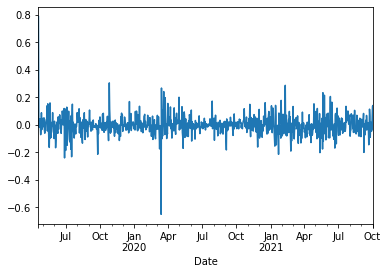

In [22]:
# training the model
results= model.fit()

# plotting residuals
results.resid.plot()

In [23]:
predictions= results.predict(start =train_size, end=train_size+test_size-2,exog=test_X)
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
print(predictions)
for i in range(len(predictions)) : 
  predictions.iloc[i,0]= predictions.iloc[i,0]+predic_garch[i]

                Pred    Actual
Date                          
2021-10-04  0.677865  0.689202
2021-10-05  0.674152  0.705125
2021-10-06  0.651283  0.746426
2021-10-07  0.700583  0.795567
2021-10-08  0.686846  0.622267
...              ...       ...
2022-01-06  0.686015  0.581123
2022-01-07  0.676811  0.654732
2022-01-08  0.675976  0.609515
2022-01-09  0.676121  0.673724
2022-01-10  0.686235  0.676622

[99 rows x 2 columns]


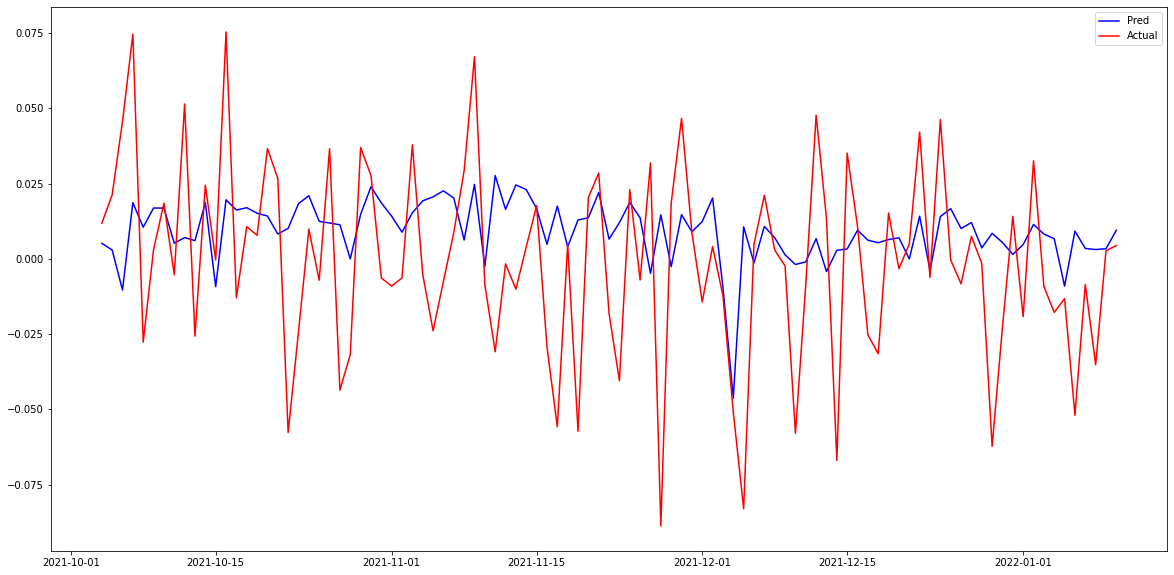

RMSE: [0.0333178]


In [24]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])

plt.figure(figsize=(20,10))
plt.plot(predictions.index, trainPredict, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.legend()
plt.show()

from statsmodels.tools.eval_measures import rmse
error=rmse(trainPredict, testPredict)
print("RMSE:",error)